Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [29]:
RANDOM_STATE = 12345

In [30]:
data = pd.read_csv('autos.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None


## В данных есть пропуски, проверим столбцы на тип и возможность заполнения пропусков

In [31]:
# Процедура, которая подскажет сколько пропусков в столбце.
# Будем использовать далее
def print_null_number(data, column):
    print(f'{column}: пропуски в {data[column].isnull().sum()} строках')

### Признаки `DateCrawled`, `DateCreated`, `LastSeen`

In [32]:
print(data['DateCrawled'][0])
print(data['DateCreated'][0])
print(data['LastSeen'][0])

2016-03-24 11:52:17
2016-03-24 00:00:00
2016-04-07 03:16:57


In [33]:
# Приведем столбцы к типу дата
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')

### Признаки `VehicleType`, `Gearbox`, `FuelType`

Логично попробовать заполнить пропущенные значения по паре Brand, Model там где это возможно.

Принцип: если по паре Brand, Model можно однозначно определить значение признака (по строкам, где признак заполнен), то будем использовать это значение для заполнения пропусков.

In [34]:
# Процедура заполняет пропуски в столбце feature по значениям признаков Brand, Model
def get_feature_by_brand_model(data, feature):
    
    isnull_before = data[feature].isnull().sum()
    
    # Отберем строки без пропусков во всех 3-х колонках
    data_filled = data.query('Brand.notnull().values and Model.notnull().values and ' + feature + '.notnull().values')

    # и получим таблицу с уникальными тройками значений колонок
    columns = ['Brand', 'Model', feature]
    data_filled = data_filled.loc[:, columns].drop_duplicates(columns).reset_index(drop=True)

    # Среди них нас интересуют только те, у которых по паре Brand, Model можно однозначно определить feature
    data_filled['count'] = 1
    data_filled = data_filled.groupby(['Brand', 'Model']).agg({feature: 'max', 'count': 'count'}).reset_index()
    data_filled.columns = ['Brand', 'Model', feature, 'count']

    # Вот собственно отбор про "однозначно определить"
    data_filled = data_filled.query('count == 1').reset_index(drop=True)
    data_filled = data_filled.drop('count', axis=1)
    
    # Cоединим data c data_filled
    data = data.merge(data_filled, on=['Brand', 'Model'], how='left', suffixes=('', '_filled'))

    # Заполним пропуски в колонке feature данными из колонки <feature>_filled
    data.loc[data[feature].isnull(), feature] = data[feature + '_filled']
    data = data.drop(feature + '_filled', axis=1)
    
    isnull_after = data[feature].isnull().sum()
    print(f'{feature}: удалось заполнить пропуски в {isnull_before - isnull_after} строках')
    
    return data

In [35]:
# VehicleType
data = get_feature_by_brand_model(data, 'VehicleType')
print(data['VehicleType'].unique())

VehicleType: удалось заполнить пропуски в 67 строках
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


In [36]:
# Gearbox
data = get_feature_by_brand_model(data, 'Gearbox')
print(data['Gearbox'].unique())

Gearbox: удалось заполнить пропуски в 143 строках
['manual' 'auto' nan]


In [37]:
# FuelType
data = get_feature_by_brand_model(data, 'FuelType')
print(data['FuelType'].unique())

FuelType: удалось заполнить пропуски в 158 строках
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


### Признак `RegistrationYear`

In [38]:
print(data['RegistrationYear'].value_counts(dropna=False).sort_index())

1000    37
1001     1
1039     1
1111     3
1200     1
        ..
9000     3
9229     1
9450     1
9996     1
9999    26
Name: RegistrationYear, Length: 151, dtype: int64


В данных присутствуют аномалии. Удаление аномалий предлагаю сделать исходя из следующей логики: 
* Если мы предполагаем, что пользователь ошибся при вводе года, то в столбце RegistrationYear укажем nan
* Если в качестве года выпуска указан год до 1900 или после 2020, то произошла ошибка (меняем на nan)
* Годы от 1900 по 1920: вероятно пользователь ошибся с веком и здесь имеется ввиду 2000-2020 годы (меняем на nan)
* Годы от 1921 по 2020: оставляем как есть

In [39]:
data.loc[(data['RegistrationYear'] < 1921) | (data['RegistrationYear'] > 2020), 'RegistrationYear'] = None
print_null_number(data, 'RegistrationYear')

RegistrationYear: пропуски в 275 строках


[[<matplotlib.axes._subplots.AxesSubplot object at 0x00000037E6335188>]]


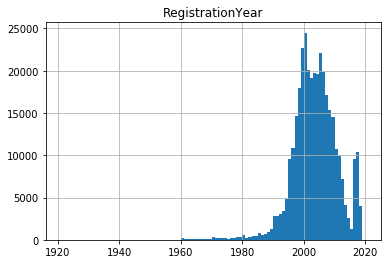

In [40]:
print(data.hist('RegistrationYear', bins=[i for i in range(1921, 2021, 1)]))

Видим, какую-то странную яму в 2015 году, но это тема для отдельного исследования (не сегодня):

In [41]:
print(data.query('RegistrationYear >= 2010 and RegistrationYear <= 2020')['RegistrationYear'].value_counts().sort_index())

2010.0    10764
2011.0     9909
2012.0     7178
2013.0     4131
2014.0     2537
2015.0     1302
2016.0     9599
2017.0    10441
2018.0     3959
2019.0       25
Name: RegistrationYear, dtype: int64


### Признак `Power`

In [42]:
print(data['Power'].value_counts(dropna=False).sort_index())

0        40225
1           34
2           10
3            9
4           30
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: Power, Length: 712, dtype: int64


В данных присутствуют аномалии. Исходим из предположения, что Power должно находится в интервале от 30 до 1300 лошадиных сил (интервал определил после изучения темы в интернете). Все остальные мощности оставляем пустыми.

In [43]:
data.loc[(data['Power'] < 30) | (data['Power'] > 1300), 'Power'] = None
print_null_number(data, 'Power')

Power: пропуски в 41372 строках


Мы убрали явные аномалии, но в таблице могли остаться просто неадекватные значения Power - например, пользователь мог вместо 100 л.с. указать 1000 л.с., и подобная аномалия останется незамеченной. 

Ниже пример, когда для "жука" заявлено 1300 л.с.

<img src=https://upload.wikimedia.org/wikipedia/commons/c/c0/1972_Volkswagen_Beetle_1.6_Rear.jpg width="30%">

In [44]:
data.query('Brand == "volkswagen" and Model == "kaefer" and VehicleType == "small"').loc[:, ['Brand', 'Model', 'Power', 'VehicleType', 'RegistrationYear']].sort_values(by='Power', ascending=False).head()

,Brand,Model,Power,VehicleType,RegistrationYear
211816,volkswagen,kaefer,1300.0,small,1972.0
74531,volkswagen,kaefer,87.0,small,1983.0
347452,volkswagen,kaefer,70.0,small,1997.0
8029,volkswagen,kaefer,68.0,small,1971.0
62461,volkswagen,kaefer,65.0,small,1970.0


Здравый смысл подсказывает, что мощность будет напрямую зависеть от:
* марки автомобиля
* модели
* типа кузова
* года выпуска (у нас это год регистрации; считаем, что это примерно одно и то же). Проблема в том, что если анализировать конкретный год, то выборка объявлений для поиска аномалий может оказаться нерепрезентативной. Поэтому добавим новую колонку RegYearGroup, и анализ мощностей будем вести по ней, а не по RegistrationYear.

In [45]:
# Заполняем RegYearGroup, все года будут делиться на указанное количество групп по квантилям 
# (чтобы в каждой группе было одинаковое количество записей)
def add_column_RegYearGroup(data, groups_number):
    if 'RegYearGroup' in list(data.columns):
        data = data.drop('RegYearGroup', axis=1)
        
    for i in range(groups_number):
        q_min = data['RegistrationYear'].quantile(q=i/groups_number)
        q_max = data['RegistrationYear'].quantile(q=(i+1)/groups_number)
        data.loc[(data['RegistrationYear'] >= q_min) & (data['RegistrationYear'] < q_max), 'RegYearGroup'] = i
        print(f'{i}: {q_min} - {q_max}')
        
    return data
            
print('RegYearGroup:')
data = add_column_RegYearGroup(data, 4)

RegYearGroup:
0: 1923.0 - 1999.0
1: 1999.0 - 2003.0
2: 2003.0 - 2008.0
3: 2008.0 - 2019.0


In [46]:
data_Power = data.query('Brand.notnull().values and Model.notnull().values and VehicleType.notnull().values and RegYearGroup.notnull().values and Power.notnull().values')
data_Power = data_Power.groupby(['Brand', 'Model', 'VehicleType', 'RegYearGroup']).agg({'Power': ['count', 'min', 'max', 'median']}).reset_index()
data_Power.columns = ['Brand', 'Model', 'VehicleType', 'RegYearGroup', 'count', 'Power_min', 'Power_max', 'Power_median']

# Дополнительно для каждой группировки хочу получить квантили Q1 и Q3, чтобы рассчитать размах усов.
# Как это сделать без цикла - не нашел
for group, data_group in data.groupby(['Brand', 'Model', 'VehicleType', 'RegYearGroup']):
    q1 = data_group['Power'].quantile(q=0.25)
    q3 = data_group['Power'].quantile(q=0.75)

    data_Power.loc[
        (data_Power['Brand'] == group[0]) 
        & (data_Power['Model'] == group[1]) 
        & (data_Power['VehicleType'] == group[2]) 
        & (data_Power['RegYearGroup'] == group[3]), 
        'Power_q1'] = q1
    
    data_Power.loc[
        (data_Power['Brand'] == group[0]) 
        & (data_Power['Model'] == group[1]) 
        & (data_Power['VehicleType'] == group[2]) 
        & (data_Power['RegYearGroup'] == group[3]), 
        'Power_q3'] = q3

data_Power['Power_boxplot_min'] = pd.DataFrame([data_Power['Power_min'], data_Power['Power_q1'] - 1.5 * (data_Power['Power_q3'] - data_Power['Power_q1'])]).max()
data_Power['Power_boxplot_max'] = pd.DataFrame([data_Power['Power_max'], data_Power['Power_q3'] + 1.5 * (data_Power['Power_q3'] - data_Power['Power_q1'])]).min()
data_Power.head(10)

,Brand,Model,VehicleType,RegYearGroup,count,Power_min,Power_max,Power_median,Power_q1,Power_q3,Power_boxplot_min,Power_boxplot_max
0,alfa_romeo,145,coupe,1.0,1,103.0,103.0,103.0,103.0,103.0,103.00,103.00
1,alfa_romeo,145,other,0.0,1,100.0,100.0,100.0,100.0,100.0,100.00,100.00
2,alfa_romeo,145,sedan,0.0,5,90.0,227.0,120.0,119.0,140.0,90.00,171.50
3,alfa_romeo,145,sedan,1.0,7,103.0,120.0,103.0,103.0,111.5,103.00,120.00
4,alfa_romeo,145,small,0.0,9,66.0,150.0,103.0,100.0,129.0,66.00,150.00
5,alfa_romeo,145,small,1.0,9,102.0,120.0,103.0,103.0,120.0,102.00,120.00
6,alfa_romeo,147,coupe,1.0,11,105.0,150.0,120.0,105.0,150.0,105.00,150.00
7,alfa_romeo,147,coupe,2.0,15,77.0,144.0,120.0,112.5,120.0,101.25,131.25
8,alfa_romeo,147,coupe,3.0,1,150.0,150.0,150.0,150.0,150.0,150.00,150.00
9,alfa_romeo,147,other,1.0,3,105.0,150.0,120.0,112.5,135.0,105.00,150.00


In [47]:
data = data.merge(
    data_Power.loc[:, ['Brand', 'Model', 'VehicleType', 'RegYearGroup', 'Power_boxplot_min', 'Power_boxplot_max']],
    on=['Brand', 'Model', 'VehicleType', 'RegYearGroup'],
    how='left'
)

# Удаление аномальных значений
data.loc[(data['Power'] < data['Power_boxplot_min']) | (data['Power'] > data['Power_boxplot_max']), 'Power'] = None
data = data.drop(['Power_boxplot_min', 'Power_boxplot_max'], axis=1)

In [48]:
print_null_number(data, 'Power')

Power: пропуски в 62113 строках


Мы долго исправляли аномалии в колонке Power. В итоге получили непростительно много пропусков в таблице. Заполним пропуски средним значением: по данным Brand, Model, VehicleType, RegYearGroup.

In [49]:
# Реализуем универсальную процедуру для заполнения пропусков по средним значениям.
# Параметры:
#     data - таблица, в которой заполняются пропуски
#     column - колонка, в которой заполняются пропуски
#     group - стоблцы, по которым вычисляется среднее значение
def fill_column_median(data, column, group):
    query_str = ''
    for col in group:
        query_str += col + '.notnull().values and '
    query_str += column + '.notnull().values'
    
    data_group = data.query(query_str).groupby(group)[column].median().reset_index()
    data_group = data_group.rename(columns={column: column + '_median'})
    
    data = data.merge(data_group, on=group, how='left')
    data.loc[(data[column].isnull()) & (data[column + '_median'].notnull()), column] = data[column + '_median']
    data = data.drop(column + '_median', axis=1)
    return data    

In [50]:
data = fill_column_median(data, 'Power', ['Brand', 'Model', 'VehicleType', 'RegYearGroup'])
print_null_number(data, 'Power')

Power: пропуски в 17927 строках


In [51]:
# Проверим, что в итоге получилось с жуком?
data.query('Brand == "volkswagen" and Model == "kaefer" and VehicleType == "small"').loc[:, ['Brand', 'Model', 'Power', 'VehicleType', 'RegistrationYear']].sort_values(by='Power', ascending=False).head()

,Brand,Model,Power,VehicleType,RegistrationYear
72739,volkswagen,kaefer,60.0,small,1964.0
90174,volkswagen,kaefer,60.0,small,1972.0
278151,volkswagen,kaefer,60.0,small,1975.0
146969,volkswagen,kaefer,50.0,small,1974.0
260526,volkswagen,kaefer,50.0,small,1973.0


In [52]:
# В конце удалим уже не нужный признак RegYearGroup
if 'RegYearGroup' in list(data.columns):
    data = data.drop('RegYearGroup', axis=1)

### Признак `Kilometer`

In [53]:
print(data['Kilometer'].value_counts(dropna=False).sort_index())

5000        6397
10000       1222
20000       3975
30000       4436
40000       4911
50000       6232
60000       7444
70000       8593
80000      10047
90000      11567
100000     14882
125000     36454
150000    238209
Name: Kilometer, dtype: int64


Аномалий не обнаружено.

### Признак `NotRepaired`

In [54]:
print(data['NotRepaired'].value_counts(dropna=False).sort_index())

no     247161
yes     36054
NaN     71154
Name: NotRepaired, dtype: int64


* Значение nan трогать не будем
* Значение yes переведем в 1
* Значение no переведем в 0

In [55]:
data.loc[data['NotRepaired'] == 'yes', 'NotRepaired'] = 1
data.loc[data['NotRepaired'] == 'no', 'NotRepaired'] = 0

In [56]:
print(data['NotRepaired'].value_counts(dropna=False).sort_index())

0.0    247161
1.0     36054
NaN     71154
Name: NotRepaired, dtype: int64


### Признак `Brand`

In [57]:
# Brand
print(np.sort(data['Brand'].unique()))

['alfa_romeo' 'audi' 'bmw' 'chevrolet' 'chrysler' 'citroen' 'dacia'
 'daewoo' 'daihatsu' 'fiat' 'ford' 'honda' 'hyundai' 'jaguar' 'jeep' 'kia'
 'lada' 'lancia' 'land_rover' 'mazda' 'mercedes_benz' 'mini' 'mitsubishi'
 'nissan' 'opel' 'peugeot' 'porsche' 'renault' 'rover' 'saab' 'seat'
 'skoda' 'smart' 'sonstige_autos' 'subaru' 'suzuki' 'toyota' 'trabant'
 'volkswagen' 'volvo']


**Итог**: мы проверили выполнили проверку данных, удалили аномалии, заполнили пропуски там где это возможно. Часть признаков анализировать нет смысла, а именно:
* Model - есть пропуски, но заполнить из не удастся; искать аномалии (типа ошибок в написании) не вижу смысла
* RegistrationMonth, PostalCode - считаю не существенными для построения модели
* NumberOfPictures - для всех строк таблицы значение = 0

# 2. Обучение моделей

Будем использовать 2 библиотеки:
* LightGBM
* CatBoost

Выделим: 
* признаки, которые НЕ будем использовать для обучения: считаем их несущественными для построения модели (например, PostalCode)
* из оставшихся признаков - выделим категориальные признаки

In [58]:
drop_features = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [59]:
# Процедура прямого кодирования
# В отличие от типового OrdinalEncoding не спотыкается об Nan
def my_OrdinalEncoder(data, features):
    for feature in features:
        unique_values = data[feature].unique()
        for i in range(len(unique_values)):
            # Проверка на nan
            if unique_values[i] != unique_values[i]:
                data.loc[data[feature].isnull(), feature] = i
            else:
                data.loc[data[feature] == unique_values[i], feature] = i

In [60]:
x = data.drop(drop_features + ['Price'], axis=1)
my_OrdinalEncoder(x, cat_features)

y = data['Price']

x_train, x_valid_test, y_train, y_valid_test = train_test_split(x, y, test_size=0.4, random_state=RANDOM_STATE)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size=0.5, random_state=RANDOM_STATE)

del x_valid_test
del y_valid_test

In [61]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354369 entries, 0 to 354368
Data columns (total 9 columns):
VehicleType         354369 non-null int64
RegistrationYear    354094 non-null float64
Gearbox             354369 non-null int64
Power               336442 non-null float64
Model               354369 non-null int64
Kilometer           354369 non-null int64
FuelType            354369 non-null int64
Brand               354369 non-null int64
NotRepaired         354369 non-null int64
dtypes: float64(2), int64(7)
memory usage: 37.0 MB


In [62]:
# Итерация градиентного бустинга
N_ITER = 100

### CatBoost

In [63]:
%%time

print('CatBoostRegressor')

best_model = None
min_rmse = 10**6

for learning_rate in np.arange(0.1, 0.51, 0.2):
    for depth in range(5, 16, 5):
        model = CatBoostRegressor(loss_function='RMSE', iterations=N_ITER, learning_rate=learning_rate, depth=depth)
        model.fit(x_train, y_train, cat_features=cat_features, verbose=0)
        pred = model.predict(x_valid)
        rmse = mean_squared_error(y_valid, pred) ** 0.5
        if rmse < min_rmse:
            best_model = model
            min_rmse = rmse
        
print(f'RMSE для valid: {min_rmse}')
print(best_model.get_params())

CatBoostRegressor
RMSE для valid: 1804.9334763699121
{'iterations': 100, 'learning_rate': 0.30000000000000004, 'depth': 15, 'loss_function': 'RMSE'}
Wall time: 5min 5s


In [64]:
%%time

pred = best_model.predict(x_test)
catboost_rmse = mean_squared_error(y_test, pred) ** 0.5
print(f'RMSE для test: {catboost_rmse}')

RMSE для test: 1817.5461511574058
Wall time: 314 ms


### LightGBM

In [65]:
%%time

print('LGBMRegressor')

best_model = None
min_rmse = 10**6

for num_leaves in range(10, 31, 10):
    for learning_rate in np.arange(0.1, 0.31, 0.1):
        for max_depth in range(5, 16, 5):
            model = LGBMRegressor(num_leaves=num_leaves, learning_rate=learning_rate, max_depth=max_depth, n_estimators=N_ITER)
            model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric='RMSE', verbose=0)
            pred = model.predict(x_valid)
            rmse = mean_squared_error(y_valid, pred) ** 0.5
            if rmse < min_rmse:
                best_model = model
                min_rmse = rmse

print(f'RMSE: {min_rmse}')
print(best_model.get_params())

LGBMRegressor
RMSE: 1854.5409885264712
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.30000000000000004, 'max_depth': 15, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 30, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Wall time: 46.5 s


In [66]:
%%time

pred = best_model.predict(x_test)
lightgbm_rmse = mean_squared_error(y_test, pred) ** 0.5
print(f'RMSE для test: {lightgbm_rmse}')

RMSE для test: 1872.189030862391
Wall time: 232 ms


# 3. Анализ моделей

In [67]:
print('|{:<15}|{:<15}|{:<15}|'.format('Модель', 'Точность, RMSE', 'Скорость'))
print('|{:<15}|{:>15}|{:>15}|'.format('Catboost', round(catboost_rmse, 2), '337 ms'))
print('|{:<15}|{:>15}|{:>15}|'.format('LightGBM', round(lightgbm_rmse, 2), '579 ms'))

|Модель         |Точность, RMSE |Скорость       |
|Catboost       |        1817.55|         337 ms|
|LightGBM       |        1872.19|         579 ms|


**Выводы о работе моделей:**
* **Скорость работы.** Обученная LightGBM работает немного быстрее, чем Catboost.
* **Качество моделей.** Качество моделей примерно одинаковое. Видимо, за счет удачного подбора гиперпараметров Catboost немного вышел вперед.